# S8 WESAD XGBoost

    Female Participant
    Age: 27
    Height (cm): 172
    Weight (kg): 64
    Note: cold during stress

## Load Tools

In [2]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.utils import class_weight
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier

In [5]:
sns.set(style="darkgrid")

In [6]:
import autoreload
%load_ext watermark
%load_ext autoreload
%autoreload 2
%watermark -a 'WForsythe' -d -t -v -p   numpy,pandas,cv2,xgboost,sklearn,seaborn,matplotlib,yellowbrick

WForsythe 2020-08-02 16:18:47 

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
pandas 1.0.3
cv2 4.2.0
xgboost 1.0.2
sklearn 0.22.1
seaborn 0.9.0
matplotlib 3.2.2
yellowbrick 1.1


## Load and Process File

### Load File

In [7]:
data = 'D:/WESAD/'
s8_file = pd.read_pickle(data + 'S8/S8.pkl')
s8_file

{'signal': {'chest': {'ACC': array([[ 8.74600053e-01, -2.31999755e-02,  2.76200056e-01],
          [ 8.80200028e-01, -1.13999844e-02,  2.63800025e-01],
          [ 8.86999965e-01,  2.00033188e-04,  2.38199949e-01],
          ...,
          [ 9.13800001e-01, -4.99999523e-03, -6.01999760e-02],
          [ 9.13800001e-01, -5.80000877e-03, -5.86000085e-02],
          [ 9.14600015e-01, -7.20000267e-03, -6.26000166e-02]]),
   'ECG': array([[ 0.16950989],
          [ 0.16639709],
          [ 0.16337585],
          ...,
          [-0.02183533],
          [-0.01629639],
          [-0.00823975]]),
   'EMG': array([[-0.00535583],
          [ 0.00993347],
          [ 0.01478577],
          ...,
          [-0.00119019],
          [-0.0100708 ],
          [-0.00979614]]),
   'EDA': array([[4.36859131],
          [4.37202454],
          [4.38194275],
          ...,
          [3.51028442],
          [3.50608826],
          [3.50456238]]),
   'Temp': array([[34.264893],
          [34.28018 ],
         

**there are 3 columns for both chest and wrist ACC and one column each for the other features**

### Process

#### Seperate chest features  from wrist  features 

In [8]:
cax = s8_file['signal']['chest']['ACC'][0:,0]
cay = s8_file['signal']['chest']['ACC'][0:,1]
caz = s8_file['signal']['chest']['ACC'][0:,2]
cecg = s8_file['signal']['chest']['ECG'][:,0]
cemg = s8_file['signal']['chest']['EMG'][:,0]
ceda = s8_file['signal']['chest']['EDA'][:,0]
ctemp = s8_file['signal']['chest']['Temp'][:,0]
cresp = s8_file['signal']['chest']['Resp'][:,0]
label = s8_file['label']

In [9]:
label

array([0, 0, 0, ..., 0, 0, 0])

#### Change dictionary object to a numpy array and array to a dataframe

In [10]:
# Python | Numpy ndarray.T
# https://www.geeksforgeeks.org/python-numpy-ndarray-t/
# Numpy Array Cookbook: Generating and Manipulating Arrays in Python
# https://towardsdatascience.com/numpy-array-cookbook-generating-and-manipulating-arrays-in-python-2195c3988b09

In [11]:
chest = [cax, cay, caz, cecg, cemg, 
         ceda, ctemp, cresp, label] 
ch_array = np.array(chest) 
ch_array = ch_array.T # transpose 
Columns = ['cax', 'cay', 'caz','cecg', 'cemg', 
          'ceda','ctemp', 'cresp', 'label' ]
ch_df = pd.DataFrame(ch_array, columns = Columns) 
ch_df

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.8746,-0.0232,0.2762,0.169510,-0.005356,4.368591,34.264893,-1.718140,0.0
1,0.8802,-0.0114,0.2638,0.166397,0.009933,4.372025,34.280182,-1.716614,0.0
2,0.8870,0.0002,0.2382,0.163376,0.014786,4.381943,34.263397,-1.705933,0.0
3,0.8954,0.0176,0.2030,0.153259,0.015884,4.365921,34.271027,-1.710510,0.0
4,0.9002,0.0326,0.1486,0.147629,0.028381,4.366684,34.261841,-1.713562,0.0
...,...,...,...,...,...,...,...,...,...
3826195,0.9150,-0.0078,-0.0558,-0.022842,0.006363,3.517151,35.528717,0.733948,0.0
3826196,0.9160,-0.0082,-0.0586,-0.024216,0.002335,3.516388,35.519409,0.730896,0.0
3826197,0.9138,-0.0050,-0.0602,-0.021835,-0.001190,3.510284,35.432373,0.727844,0.0
3826198,0.9138,-0.0058,-0.0586,-0.016296,-0.010071,3.506088,35.547394,0.703430,0.0


##### Check Statistics

In [12]:
ch_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,3826200.0,0.824711,0.089931,-0.473400,0.780200,0.842600,0.897000,2.328600
cay,3826200.0,-0.087701,0.134317,-0.775800,-0.179600,-0.070600,0.001800,0.640800
caz,3826200.0,-0.270723,0.293661,-1.798400,-0.491400,-0.307000,-0.041800,2.261800
cecg,3826200.0,0.001477,0.266321,-1.440353,-0.077042,-0.017899,0.017624,1.499954
cemg,3826200.0,-0.002612,0.019346,-1.250198,-0.010025,-0.002060,0.005081,1.031433
ceda,3826200.0,3.782816,0.192292,3.295898,3.669357,3.759384,3.854752,5.717850
ctemp,3826200.0,35.014137,0.311258,33.630707,34.861572,35.017365,35.201355,35.776520
cresp,3826200.0,0.067162,3.574538,-24.359131,-1.795959,-0.077820,1.976013,22.613525
label,3826200.0,1.412002,1.635803,0.000000,0.000000,1.000000,2.000000,7.000000


##### Check Type

In [13]:
print(ch_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3826200 entries, 0 to 3826199
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cax     float64
 1   cay     float64
 2   caz     float64
 3   cecg    float64
 4   cemg    float64
 5   ceda    float64
 6   ctemp   float64
 7   cresp   float64
 8   label   float64
dtypes: float64(9)
memory usage: 262.7 MB
None


##### Show label classes sequence plot
    Classes: 0 = Undefined, 1 = Baseline, 2 = Stress, 3 = Amusement, 4 = Meditation
    Classes 5, 6, and 7 are periods in which questionnaires were given

3826200


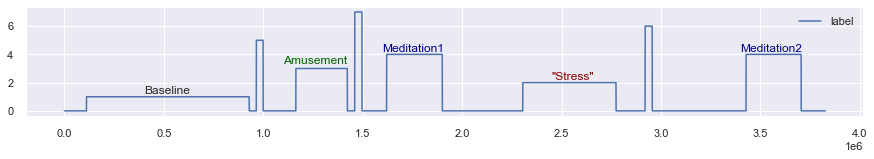

In [14]:
ch_df[["label"]].plot(figsize=(15,2))
plt.text(400000,1.2,'Baseline'), plt.text(2450000,2.2,'"Stress"', c = 'darkred'), plt.text(1600000,4.2,'Meditation1', c = 'darkblue')
plt.text(1100000,3.3,'Amusement', c = 'darkgreen'), plt.text(3400000,4.2,'Meditation2', c = 'darkblue')
print(len(label))

### Concatenate classes 0, 1, 2, 3, and 4

In [15]:
loc0 = ch_df.loc[ch_df['label'] == 0]
loc1 = ch_df.loc[ch_df['label'] == 1]
loc2 = ch_df.loc[ch_df['label'] == 2]
loc3 = ch_df.loc[ch_df['label'] == 3]
loc4 = ch_df.loc[ch_df['label'] == 4]

In [16]:
ch_loc = pd.concat([loc0, loc1, loc2, loc3, loc4])
ch_loc

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.8746,-0.0232,0.2762,0.169510,-0.005356,4.368591,34.264893,-1.718140,0.0
1,0.8802,-0.0114,0.2638,0.166397,0.009933,4.372025,34.280182,-1.716614,0.0
2,0.8870,0.0002,0.2382,0.163376,0.014786,4.381943,34.263397,-1.705933,0.0
3,0.8954,0.0176,0.2030,0.153259,0.015884,4.365921,34.271027,-1.710510,0.0
4,0.9002,0.0326,0.1486,0.147629,0.028381,4.366684,34.261841,-1.713562,0.0
...,...,...,...,...,...,...,...,...,...
3704767,0.6554,0.0192,-0.6834,0.478180,-0.015289,3.532410,35.581635,2.293396,4.0
3704768,0.6538,0.0200,-0.6806,0.262756,-0.003937,3.532791,35.511627,2.265930,4.0
3704769,0.6542,0.0222,-0.6806,0.103363,0.004532,3.535461,35.586304,2.253723,4.0
3704770,0.6532,0.0222,-0.6818,-0.013000,-0.007095,3.535461,35.597229,2.250671,4.0


#### Check Statistics

In [17]:
ch_loc.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,3719799.0,0.822315,0.090039,-0.473400,0.778600,0.837800,0.894000,2.328600
cay,3719799.0,-0.088365,0.136074,-0.775800,-0.182400,-0.069000,0.003000,0.640800
caz,3719799.0,-0.276392,0.295248,-1.798400,-0.499800,-0.324600,-0.047000,2.261800
cecg,3719799.0,0.001470,0.266494,-1.440353,-0.077316,-0.018036,0.017532,1.499954
cemg,3719799.0,-0.002611,0.019383,-1.250198,-0.010025,-0.002060,0.004990,1.031433
ceda,3719799.0,3.782342,0.194464,3.295898,3.664398,3.757858,3.853989,5.717850
ctemp,3719799.0,35.012175,0.315127,33.630707,34.853912,35.014282,35.205963,35.776520
cresp,3719799.0,0.066212,3.587294,-24.359131,-1.789856,-0.057983,1.991272,22.613525
label,3719799.0,1.280203,1.452146,0.000000,0.000000,1.000000,2.000000,4.000000


#### Plot all classes vs. classes 0,1,2,3,4 

3826200 3719799
Number of Rows Removed: 106401


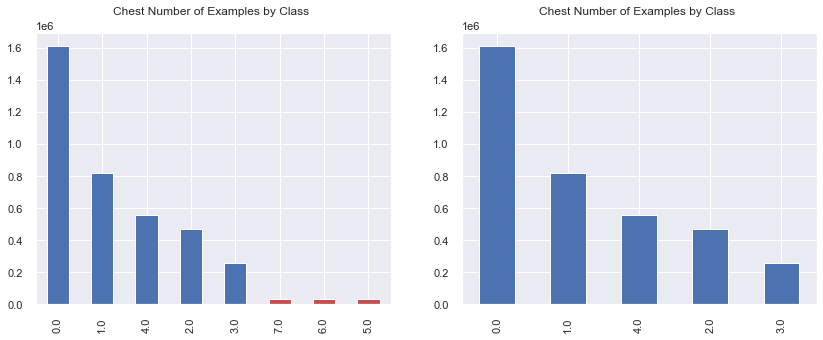

In [18]:
sns.set(style="darkgrid")
plt.figure(figsize = (14,5))
plt.subplot(1, 2, 1)
ch_df['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n',
                                     color=['b','b','b','b','b','r','r','r'])
plt.subplot(1, 2, 2)
ch_loc['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n')
print((ch_df['label'].value_counts().sum()), ch_loc['label'].value_counts().sum())
print('Number of Rows Removed:', (ch_df['label'].value_counts().sum()) - 
      ch_loc['label'].value_counts().sum());

# Model Runs: XGBoost Classifier

**XGBoost for Multi-class Classification** <br>
https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

## Model allChest: All chest features

### Train Test

In [21]:
y = ch_loc.label
x = ch_loc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)
evalSet = [(x_train, y_train), (x_test, y_test)]

(2975839, 8)
(743960,)


### Model Fit and f1 and Balanced Accuracy Scores

In [23]:
%%time
allChest = xgb.XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 300, 
                              max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              seed = 24,
                              verbosity = 2) 

model_allChest = allChest.fit(x_train,y_train) # , class_weight=class_weights
allChest_pred = allChest.predict(x_test)
allChest_report = (classification_report(y_test,
                                         allChest_pred,
                                         labels=np.unique(allChest_pred),
                                         digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, allChest_pred))
print('----------------------------------------')
print('------------ S8 All Chest Classification Report------------')
print(allChest_report)

Balanced Accuracy: 0.9924485846269185
----------------------------------------
------------ S11 All Chest Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9932    0.9873    0.9903    323786
         1.0     0.9949    0.9981    0.9965    163444
         2.0     0.9865    0.9920    0.9893     93335
         3.0     0.9828    0.9908    0.9868     51852
         4.0     0.9901    0.9940    0.9920    111543

    accuracy                         0.9915    743960
   macro avg     0.9895    0.9924    0.9910    743960
weighted avg     0.9915    0.9915    0.9915    743960

Wall time: 1min 35s


### Confusion Matrix

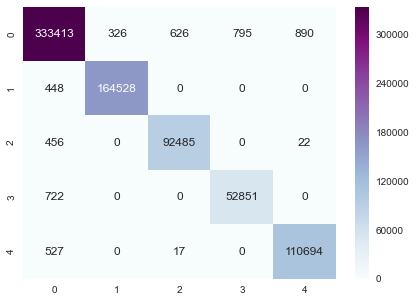

In [23]:
cm = confusion_matrix(y_test, allChest_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

## Model ACC TEMP EDA

### Test Train Split

In [19]:
less_Emg_Ecg = ch_loc[['ceda', 'ctemp', 'cax', 'cay', 'caz', 'label']]
y = less_Emg_Ecg.label
x = less_Emg_Ecg.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(2975839, 5)
(743960,)


### Model Fit, classification report, and Balanced Accuracy 

In [20]:
%%time
accEdaTemp = XGBClassifier(objective = 'multi:softmax',
                           tree_method = 'gpu_hist',
                           learning_rate = 0.1,
                           gradient_based = 0.1,
                           num_early_stopping_rounds = 20,
                           n_estimators = 300,
                           gamma = 3,
                           verbosity = 2) 

model_accEdaTemp = accEdaTemp.fit(x_train, y_train)
accEdaTemp_pred = accEdaTemp.predict(x_test)
accEdaTemp_report = (classification_report(y_test, 
                                         accEdaTemp_pred, 
                                         labels = np.unique(accEdaTemp_pred),
                                         digits = 4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, accEdaTemp_pred))
print('---------------------------------------')
print('------------ S8 ACC EDA TEMP Classification Report------------')
print(accEdaTemp_report)

Balanced Accuracy: 0.986073770294389
---------------------------------------
------------ S8 ACC EDA TEMP Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9864    0.9788    0.9826    323612
         1.0     0.9930    0.9972    0.9951    163957
         2.0     0.9729    0.9808    0.9768     93362
         3.0     0.9766    0.9860    0.9813     51683
         4.0     0.9827    0.9875    0.9851    111346

    accuracy                         0.9849    743960
   macro avg     0.9823    0.9861    0.9842    743960
weighted avg     0.9849    0.9849    0.9849    743960

Wall time: 1min 14s


### Confusion matrix

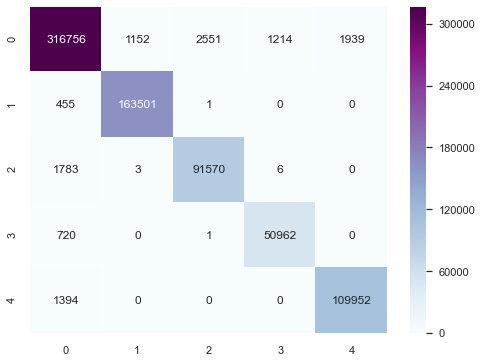

In [21]:
cm = confusion_matrix(y_test, accEdaTemp_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );